In [11]:
%load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from tensorboardX import SummaryWriter
from sklearn.metrics import f1_score
from tqdm import tqdm_notebook

from dataset import MNISTDataset
from models import CNN

In [13]:
def imshow(img, title=None):
    plt.imshow(img/(np.max(img)-np.min(img)))
    if title is not None:
        plt.title(title)
    plt.show()

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [15]:
data_dir = 'data/'
validation_split = 0.2
batch_size = 64
num_workers = 3
image_size = (64, 64)
num_classes = 10
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [16]:
train_set = MNISTDataset(os.path.join(data_dir, 'train_small.npz'), transform=transform)
val_set = MNISTDataset(os.path.join(data_dir, 'val_small.npz'), transform=transform)

In [17]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers)

In [18]:
dropout = 0.275

model = CNN(input_shape=(1, *image_size), dropout=dropout, num_classes=num_classes)
model = model.to(device)

criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=0.005)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True)

num_epochs = 50
train_steps_per_epoch = int((len(train_set)+1)/batch_size)
val_steps_per_epoch = int((len(val_set)+1)/batch_size)
models_dir = 'models/'
model_name = 'CNN-small-adam'

In [9]:
writer = SummaryWriter(comment=model_name)

best_val_loss = float('inf')
print('Started Training')
for epoch in range(num_epochs):
    
    model.train(True)
    train_loss = 0.0
    for i, data in tqdm_notebook(enumerate(train_loader, 0),
                                 total=train_steps_per_epoch,
                                 desc='Epoch {}: '.format(epoch)):
        x,y = data.values()
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        p = model(x)
        loss = criterion(p, y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if i >= train_steps_per_epoch:
            break
    writer.add_scalar('train_loss', train_loss / (len(train_set)/batch_size), epoch)
    
    model.eval()
    val_loss = 0.0
    y_true = None
    y_pred = None
    for i, data in enumerate(val_loader, 0):
        x,y = data.values()
        x = x.to(device)
        y = y.to(device)
        p = model(x)
        loss = criterion(p, y.float())
        val_loss += loss.item()
        if y_true is None:
            y_true = y
        else:
            y_true = torch.cat([y_true, y], dim=0)
            
        if y_pred is None:
            y_pred = y.byte()
        else:
            y_pred = torch.cat([y_pred, (torch.sigmoid(p).data > 0.5)], dim=0)

        if i >= val_steps_per_epoch:
            break
            
    y_true = torch.transpose(y_true, 0, 1).cpu().numpy()
    y_pred = torch.transpose(y_pred, 0, 1).cpu().numpy()

    f1score = []

    for i in range(num_classes):
        f1score.append(f1_score(y_true[i], y_pred[i]))

    avg_f1score = np.average(f1score)
    
    writer.add_scalar('validation_loss', val_loss / (len(val_set)/batch_size), epoch)
    writer.add_scalar('average f1-score on val. set', avg_f1score, epoch)
    
    print('train_loss: %.5f, validation_loss: %.5f, validation_f1-score: %.3f' % 
          (train_loss / (len(train_set)/batch_size), val_loss / (len(val_set)/batch_size), avg_f1score))
    
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), os.path.join(models_dir, model_name))
        best_val_loss = val_loss
        print('Model Saved!')
        
    train_loss = 0.0
    val_loss = 0.0
            
print('Finished Training')

Started Training



train_loss: 0.37507, validation_loss: 0.33686, validation_f1-score: 0.062
Model Saved!



train_loss: 0.34106, validation_loss: 0.32998, validation_f1-score: 0.062
Model Saved!



train_loss: 0.32978, validation_loss: 0.31237, validation_f1-score: 0.062
Model Saved!



train_loss: 0.31459, validation_loss: 0.29872, validation_f1-score: 0.062
Model Saved!



train_loss: 0.30399, validation_loss: 0.28752, validation_f1-score: 0.062
Model Saved!



train_loss: 0.29228, validation_loss: 0.28352, validation_f1-score: 0.062
Model Saved!



train_loss: 0.28408, validation_loss: 0.26728, validation_f1-score: 0.062
Model Saved!



train_loss: 0.27494, validation_loss: 0.25605, validation_f1-score: 0.083
Model Saved!



train_loss: 0.27182, validation_loss: 0.25863, validation_f1-score: 0.086



train_loss: 0.26593, validation_loss: 0.24691, validation_f1-score: 0.065
Model Saved!



train_loss: 0.26212, validation_loss: 0.24252, validation_f1-score: 0.167
Model Saved!



train_loss: 0.25772, validation_loss: 0.23917, validation_f1-score: 0.202
Model Saved!



train_loss: 0.25460, validation_loss: 0.23936, validation_f1-score: 0.203



train_loss: 0.25256, validation_loss: 0.23233, validation_f1-score: 0.181
Model Saved!



train_loss: 0.24923, validation_loss: 0.23064, validation_f1-score: 0.234
Model Saved!



train_loss: 0.24781, validation_loss: 0.22810, validation_f1-score: 0.254
Model Saved!



train_loss: 0.24556, validation_loss: 0.23457, validation_f1-score: 0.204



train_loss: 0.24403, validation_loss: 0.22526, validation_f1-score: 0.279
Model Saved!



train_loss: 0.23944, validation_loss: 0.22602, validation_f1-score: 0.243



train_loss: 0.23863, validation_loss: 0.22457, validation_f1-score: 0.291
Model Saved!



train_loss: 0.23867, validation_loss: 0.22218, validation_f1-score: 0.299
Model Saved!



train_loss: 0.23795, validation_loss: 0.22545, validation_f1-score: 0.297



train_loss: 0.23620, validation_loss: 0.21952, validation_f1-score: 0.322
Model Saved!



train_loss: 0.23569, validation_loss: 0.22342, validation_f1-score: 0.284



train_loss: 0.23293, validation_loss: 0.21820, validation_f1-score: 0.309
Model Saved!



train_loss: 0.23064, validation_loss: 0.22197, validation_f1-score: 0.319



train_loss: 0.23299, validation_loss: 0.21539, validation_f1-score: 0.320
Model Saved!



train_loss: 0.23139, validation_loss: 0.21941, validation_f1-score: 0.315



train_loss: 0.23126, validation_loss: 0.21691, validation_f1-score: 0.349



train_loss: 0.22743, validation_loss: 0.21651, validation_f1-score: 0.350



train_loss: 0.22831, validation_loss: 0.21397, validation_f1-score: 0.343
Model Saved!



train_loss: 0.22987, validation_loss: 0.21609, validation_f1-score: 0.325



train_loss: 0.22898, validation_loss: 0.21212, validation_f1-score: 0.360
Model Saved!



train_loss: 0.22691, validation_loss: 0.21497, validation_f1-score: 0.361



train_loss: 0.22650, validation_loss: 0.21198, validation_f1-score: 0.349
Model Saved!



train_loss: 0.22560, validation_loss: 0.20916, validation_f1-score: 0.370
Model Saved!



train_loss: 0.22394, validation_loss: 0.20912, validation_f1-score: 0.354
Model Saved!



train_loss: 0.22257, validation_loss: 0.20820, validation_f1-score: 0.343
Model Saved!



train_loss: 0.22179, validation_loss: 0.20619, validation_f1-score: 0.381
Model Saved!



train_loss: 0.22417, validation_loss: 0.20991, validation_f1-score: 0.321



train_loss: 0.22125, validation_loss: 0.21057, validation_f1-score: 0.392



train_loss: 0.22061, validation_loss: 0.20942, validation_f1-score: 0.347



train_loss: 0.21898, validation_loss: 0.20624, validation_f1-score: 0.373



train_loss: 0.21822, validation_loss: 0.20491, validation_f1-score: 0.384
Model Saved!



train_loss: 0.21707, validation_loss: 0.20709, validation_f1-score: 0.352



train_loss: 0.21737, validation_loss: 0.20552, validation_f1-score: 0.405



train_loss: 0.21405, validation_loss: 0.20270, validation_f1-score: 0.392
Model Saved!



train_loss: 0.21559, validation_loss: 0.20698, validation_f1-score: 0.385



train_loss: 0.21512, validation_loss: 0.20277, validation_f1-score: 0.392



train_loss: 0.21313, validation_loss: 0.19659, validation_f1-score: 0.425
Model Saved!
Finished Training


In [ ]:
torch.save(model.state_dict(), os.path.join(models_dir, 'cnn_best'))

In [19]:
model.load_state_dict(torch.load(os.path.join(models_dir,'cnn_best')))

In [27]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for data in val_loader:
        images, labels = data.values()
        images = images.cuda(device)
        outputs = model(images)
        y_true += list(labels.numpy())
        y_pred += list((torch.sigmoid(outputs).data > 0.5 ).cpu().numpy())
        
y_true = np.asarray(y_true).T
y_pred = np.asarray(y_pred).T

f1score = []

for i in range(num_classes):
    f1score.append(f1_score(y_true[i], y_pred[i]))
    
avg_f1score = np.average(f1score)
    
print(f1score)
print('Average f1-score = {}'.format(avg_f1score))

[0.7752808988764044, 0.8517745302713987, 0.4982456140350877, 0.7435897435897436, 0.7469135802469136, 0.7492795389048992, 0.7407407407407407, 0.7815533980582524, 0.7223880597014926, 0.7354838709677419]
Average f1-score = 0.7345249975392674


In [62]:
idx = np.random.randint(0, len(val_set), size=1)

[8] [8]


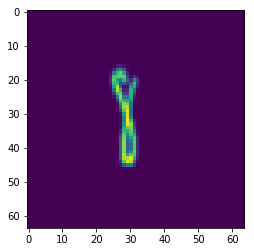

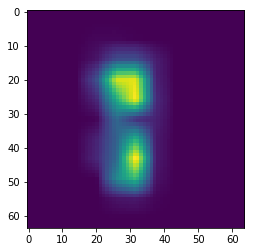

In [63]:
with torch.no_grad():
    x, y = val_set[idx[0]].values()
    x = x[None, :, :].to(device)
    f = model.visualise_features(x, True)
    output = model(x)
    p = np.where(torch.sigmoid(output).data.cpu().numpy() > 0.5)[1]
    y = np.where(y == 1)[0]
    im = x[0][0].cpu().numpy()
    im_f = f

print(y, p)
imshow(im)
imshow(im_f)